# Person - forecasting

The purpose here is to generate the most accurate hourly forecast given a set of data points with collected and engineered features.

In [395]:
# import ConfigImports Notebook to import and configure libs
%run ../ConfigImports.ipynb

### Load dataset

In [396]:
filename = '../Datasets/Person_features__2019-09-09_2020-03-02.pickle'
infile = open(filename,'rb')
(numerical, dummies, cyclical, raw_data), y = pickle.load(infile)
infile.close()

### Remove unpopular targets

Even though most of the outliers have been removed previously, if we plot the count distribution, we can see that the number of 6-8 observation per hour is so low, that it will actually confuse the model

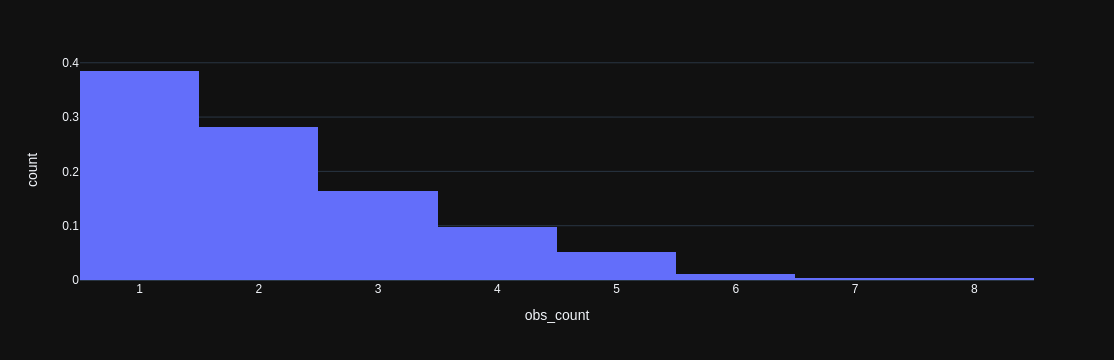

In [401]:
idx = raw_data['obs_count'] > 0
px.histogram(raw_data[idx], x="obs_count", height=300, width=600, nbins=8, histnorm='probability density')

An analytical method I will use to deal with this is to only include the counts, which represent 98% of the data.

In case of this dataset, it will only keep the counts within teh healthy range of 0-5.

In [404]:
# what is the 98% of the dataset?
max_count = raw_data['obs_count'].quantile(0.98)
print('Max count to keep:', max_count)
idx = raw_data['obs_count'] <= max_count
raw_data = raw_data.loc[idx]

Max count to keep: 5.0


### Filter out nightly hours dilemma

For now I am making a decision to include the night-time hours.

But this can be changed based on the following fact: Current data collection and specifically lack of a night vision camera drives all nightly observations to pretty much 0.

If we wanted to, we could use the daily sunrise and sunset time to exclude only relevant data points, instead of blindly removing too much data. This code snippet could do this for us:

```python
# convert timestamps to hours
conv_ts = lambda x: datetime.fromtimestamp(x).hour
df['sunrise_hour'] = df['daily__sunriseTime'].apply(conv_ts)
df['sunset_hour'] = df['daily__sunsetTime'].apply(conv_ts)

# remove nightly records
idx = (df['hour'] < df['sunrise_hour']) | (df['hour'] > df['sunset_hour'])
df = df.loc[~idx]
```

It might be a good idea to revisit this when deciding on the final model to use

### Baseline simple model (without Machine Learning)

Firstly - create a crude model, which will use hourly averages to generate a forecast.

Even though this model is very simplistic, it is actually quite robust, very fast to execute and easy to explain.

In [602]:
# create a train/test split for the dataset
X = raw_data[['hour', 'obs_count']]
X_train, X_test, y_train, y_test = train_test_split(
    X, raw_data['obs_count'], test_size=0.25, random_state=0)

In [603]:
# calculate hourly averages of counts for training set
mean_obj_counts = X_train.groupby('hour')['obs_count'].mean()

In [604]:
# now we can generate the predictions for the test set
y_pred = X_test['hour'].map(mean_obj_counts)

In [605]:
# round results
y_pred_rounded = [round(p) for p in y_pred]

In [611]:
# calculate scores
print('mse:', mean_squared_error(y_test, y_pred_rounded))
print('mae', mean_absolute_error(y_test, y_pred_rounded))

mse: 1.6983471074380165
mae 1.0020661157024793


Even though the mean squared error is a good metric to utilise in the analytical framework (high errors should be penalised more), it is easier to interpret the mean absolute error in a visual mode.

Absolute error is calculated as: $$error=abs(y\_test-y\_pred)$$

Histogram below shows the magnitute of mistakes made by the model, the lower the count on the y-axis and the more it is clustered to zero on the x-asis, the better the model is.

Total abs error: 606
Total correct samples: 552  from  968
Total accuracy:  0.57
Accuracy for obs_count > 0:  0.32


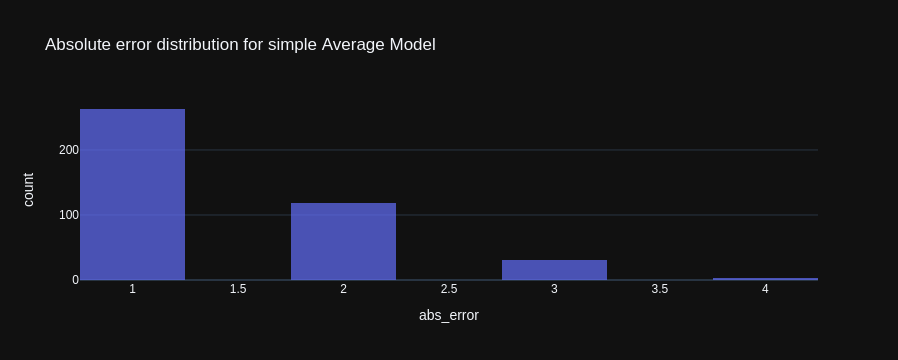

In [607]:
# calculate absolute error and plot a histogram
X_test_cp = X_test.copy()
X_test_cp['predicted'] = y_pred_rounded
X_test_cp['abs_error'] = (X_test_cp['obs_count'] - X_test_cp['predicted']).abs()
print('Total abs error:', X_test_cp['abs_error'].sum())
idx = X_test_cp['abs_error'] == 0
print('Total correct samples:', X_test_cp[idx].shape[0], ' from ', X_test_cp.shape[0])
print('Total accuracy: ', round(X_test_cp[idx].shape[0] / X_test_cp.shape[0], 2))
idx_total = (X_test_cp['obs_count'] > 0)
idx_total_correct = (X_test_cp['obs_count'] > 0) & (X_test_cp['abs_error'] == 0)
print('Accuracy for obs_count > 0: ',
      round(X_test_cp[idx_total_correct].shape[0] / X_test_cp[idx_total].shape[0], 2))
idx = X_test_cp['abs_error'] > 0
px.histogram(X_test_cp[idx], x="abs_error", opacity=0.7, height=300, nbins=8,
             title='Absolute error distribution for simple Average Model')

### Prepare X and y

- define X and y
- split into traning and testing
- scale data

In [612]:
# these features have been studied to produce the best results across all models
cust_cols = ['hour', 'n_month', 'is_weekend_day', 'cur__precipProbability', 
             'cur__apparentTemperature', 'cur__windGust']
X = raw_data[cust_cols]

# split into training/testing
X_train, X_test, y_train, y_test = train_test_split(
    X, raw_data['obs_count'], test_size=0.25, random_state=0)

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [613]:
# define a reusable method to plot the distibution of absolute error
def plot_abs_err(y_pred, model_name=''):
    X_test_cp = X_test.copy()
    X_test_cp['obs_count'] = y_test
    X_test_cp['predicted'] = y_pred
    X_test_cp['abs_error'] = (X_test_cp['obs_count'] - X_test_cp['predicted']).abs()
    print('Total abs error:', X_test_cp['abs_error'].sum())
    idx = X_test_cp['abs_error'] == 0
    print('Total correct samples:', X_test_cp[idx].shape[0], ' from ', X_test_cp.shape[0])
    print('Accuracy: ', round(X_test_cp[idx].shape[0] / X_test_cp.shape[0], 2))
    idx_total = (X_test_cp['obs_count'] > 0)
    idx_total_correct = (X_test_cp['obs_count'] > 0) & (X_test_cp['abs_error'] == 0)
    print('Accuracy for obs_count > 0: ', 
          round(X_test_cp[idx_total_correct].shape[0] / X_test_cp[idx_total].shape[0], 2))
    idx = X_test_cp['abs_error'] > 0
    fig = px.histogram(X_test_cp[idx], x="abs_error", opacity=0.7, height=325, width=800,
                       nbins=8, title=f'Absolute error distribution for {model_name} Model')
    fig.show()

### Machine Learning linear model (Linear Regression)

Can an ML model pick up on linear relationships between features and improve the baseline model?

mse: 1.6983471074380165
mae: 1.0020661157024793
Total abs error: 970.0
Total correct samples: 223  from  968
Accuracy:  0.23
Accuracy for obs_count > 0:  0.34


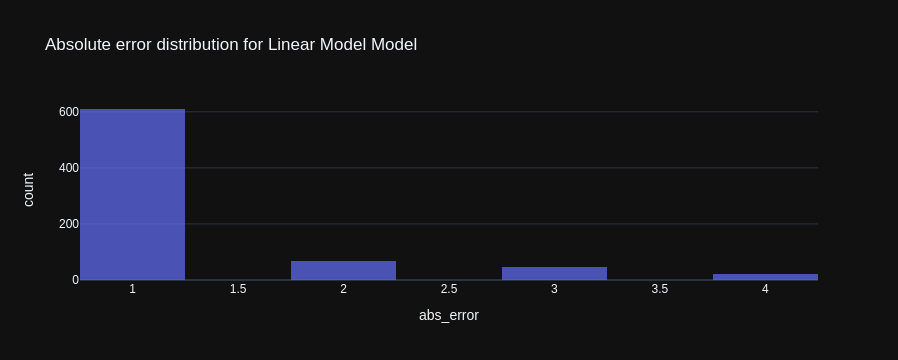

In [614]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# round results to nearest int
y_pred_rounded = [round(p) for p in y_pred]

# calculate scores
print('mse:', mean_squared_error(y_test, y_pred_rounded))
print('mae:', mean_absolute_error(y_test, y_pred_rounded))

plot_abs_err(y_pred_rounded, 'Linear Model')

As can be seen in the statistics above, the linear Machine Learning model is actually much worse than the simple averages model. It's also not powerful enough to exploit any non-linear relationships between features and the output variable.

### Random Forest model

Can an ML model pick up on non-linear relationships between features and improve the baseline model?

In [615]:
# handy utility function to merge multiple dataframes
def merge_datasets(datasets):
    """
    Usages:
    - merge_datasets([numerical, dummies, cyclical])
    - merge_datasets([dummies, cyclical])
    - merge_datasets([numerical, dummies])
    """
    df = datasets[0].copy()
    for d_next in datasets[1:]:
        df = df.merge(d_next, left_index=True, right_index=True)
    return df

In [616]:
from sklearn.ensemble import RandomForestRegressor

In [617]:
X = merge_datasets([numerical, dummies, cyclical])

# split into training/testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [618]:
# fit model and make predictions
model = RandomForestRegressor(n_estimators=100, criterion='mse')
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# round results to nearest int
y_pred_rounded = np.array([int(round(p)) for p in y_pred])

print('mse:', mean_squared_error(y_test, y_pred_rounded))
print('mae', mean_absolute_error(y_test, y_pred_rounded))

# verify predictions versus the actual counts to make sure the predictions do make sense,
# for example model is not predicting high counts during the night or during the high gusts
print(y_pred_rounded[:10].tolist())
print(y_test[:10].tolist())

mse: 1.08
mae 0.5938461538461538
[0, 0, 1, 2, 3, 1, 1, 0, 0, 1]
[0, 0, 0, 2, 3, 1, 2, 0, 0, 0]


As we can see, based on the output above - Random Forest does an ok enough job at predicting the counts. I have also tested SVM (using SVR class in sklearn) but it did not show any improvement over the Random Forest model.

Total abs error: 579
Total correct samples: 581  from  975
Accuracy:  0.6
Accuracy for obs_count > 0:  0.33


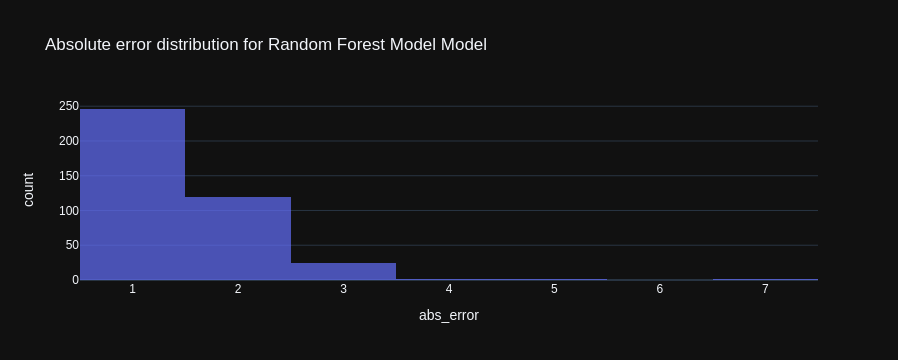

In [619]:
plot_abs_err(y_pred_rounded, 'Random Forest Model')

### Test Neural Network approach

I have tested many variations of the Feed Forward Neural Network.

The best performing (and also fitting the purpose) turned out to be a simple Network with only a single, 12 neuron hidden layer.

Increasing model's complexity results in overfitting, as we only have ~3000 data points in the training sample. As seen in the model summary below, our model has 193 trainable parameters, and according to the best practices in Deep Learning, we should always have 10x more data samples than parameters in the model.

Activation functions have been chosen carefully to fit the purpose:
- hidden layer uses **relu** (as a standard in modern neural network hidden layers)
- output layer uses **exponential** (as outputs should not be negative and it's used for modelling count data)

Lowering learning rate resulted in a much more smooth loss curve.

Training the model for 50 epochs was the sweet spot to achieve the convergence.

The predictions generated by the model had to be rounded to the nearest integer, as we are modelling the count data (which should not be a floating point type).

In [632]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.activations import exponential

In [663]:
# Define layers
inputs = Input(shape=(X.shape[1],))
x = Dense(12, activation="relu")(inputs)
# x = Dense(12, activation="relu")(x)
outputs = Dense(1, activation="exponential")(x)
# Create model
model = Model(inputs=inputs, outputs=outputs, name="nn_reg_model")
opt = Adam(learning_rate=0.0013)
model.compile(loss='mse', optimizer=opt, metrics=['mse','mae'])
model.summary()

Model: "nn_reg_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_186 (InputLayer)       [(None, 14)]              0         
_________________________________________________________________
dense_468 (Dense)            (None, 12)                180       
_________________________________________________________________
dense_469 (Dense)            (None, 1)                 13        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


mse: 1.1692307692307693
mae 0.6051282051282051


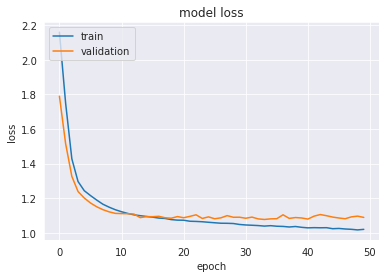

In [660]:

history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32,
                    verbose=0, validation_data=(X_test_scaled, y_test))
# Predict and calculate stats
y_pred = model.predict(X_test_scaled)

# Round to nearest int and clip at 0 (no negatives are allowed)
y_pred_rounded = np.array([int(round(p[0])) for p in y_pred])

# Print scores
print('mse:', mean_squared_error(y_test, y_pred_rounded))
print('mae', mean_absolute_error(y_test, y_pred_rounded))

# Plot "Loss" over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Analysis:
- The validation loss curve looks a smooth enough, which indicates a good choice of learning rate
- There is no overfitting visible, as validation loss does not jump upwards
- Model converges after 40 epochs my minimising the means squared error ($mse$) to ~$1.17$

In [661]:
# verify predictions versus the actual counts to make sure the predictions do make sense,
# for example model is not predicting high counts during the night or during the high gusts
print(y_pred_rounded[:10].tolist())
print(y_test[:10].tolist())

[0, 0, 2, 2, 3, 2, 1, 0, 0, 2]
[0, 0, 0, 2, 3, 1, 2, 0, 0, 0]


Total abs error: 590
Total correct samples: 592  from  975
Accuracy:  0.61
Accuracy for obs_count > 0:  0.32


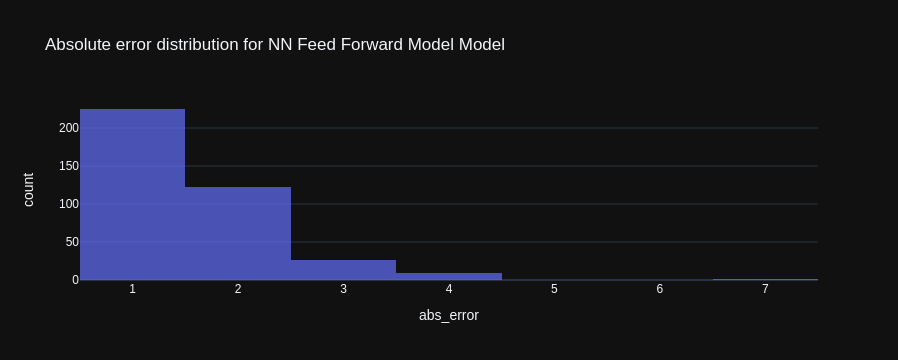

In [662]:
plot_abs_err(y_pred_rounded, 'NN Feed Forward Model')

So far, the **NN Feed Forward** model has the best error statistics so far in terms of all the Neural Networs I have tested so far. But the results are almost the same as the **Random Forests** model.

I have also tested a Poisson family model (**Zero inflated Negative Bonomial**), which is used to model a distibution of count data dominated by zeros.

Inspired by an excellent implementation available [here in Colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_06/nb_ch06_02.ipynb#scrollTo=FQFfRlKfLjUi), the results did not show any improvement over the simple Feed Forward Network (the best results were 20% worse), so I have excluded it from this analysis.

### LSTM Recurrent NN